#### LangGraph With Tools

In [1]:
##Tools 
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun 
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper 

api_wrapper_arxiv = ArxivAPIWrapper(top_k_results= 3, doc_content_chars_max= 300)
arxiv = ArxivQueryRun(api_wrapper= api_wrapper_arxiv, description = "Query arxiv paper")
print(arxiv)

description='Query arxiv paper' api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=3, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=300)


In [2]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [3]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max= 300)
wiki = WikipediaQueryRun(api_wrapper= api_wrapper_wiki)
print(wiki)

api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'c:\\PythonCSV\\CSV_file\\LangGraph\\LangGraphBasics\\.venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=300)


In [4]:
#Loading environment variable from .env file 
from dotenv import load_dotenv 
import os 

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [5]:
##Tavily Search tool 
from langchain_community.tools.tavily_search import TavilySearchResults 

tavily = TavilySearchResults(max_results= 3)

C:\Users\Abhijeet\AppData\Local\Temp\ipykernel_17552\1533557354.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults(max_results= 3)


In [6]:
tavily.invoke("Provide me the recent AI news")

[{'title': 'NSF, NVIDIA Partner in $152M Ai2-Led Project to Build Open AI Models for US Science',
  'url': 'https://www.hpcwire.com/off-the-wire/nsf-nvidia-partner-in-152m-ai2-led-project-to-build-open-ai-models-for-us-science/',
  'content': "Aug. 14, 2025 — The U.S. National Science Foundation has announced a partnership with NVIDIA to develop a set of artificial intelligence models that will transform the ability of America's scientists to leverage AI, advancing scientific discovery and ensuring U.S. leadership in AI-powered research and innovation.",
  'score': 0.98573},
 {'title': 'AI News | Latest AI News, Analysis & Events',
  'url': 'https://www.artificialintelligence-news.com/',
  'content': 'NVIDIA expands Blackwell-powered servers with new AI and robotics capabilities. Applications. August 12, 2025. NVIDIA latest: Blackwell GPU and software updates.',
  'score': 0.98531},
 {'title': 'The State of AI 2025',
  'url': 'https://www.bvp.com/atlas/the-state-of-ai-2025',
  'content

In [7]:
#Combine all tools  in the list 
tools = [arxiv, wiki, tavily]

In [8]:
#Initialize the LLM model 
from langchain_groq import ChatGroq 

llm = ChatGroq(model = "meta-llama/llama-4-maverick-17b-128e-instruct")

In [9]:
llm.invoke("What is AGI?")

AIMessage(content='AGI stands for Artificial General Intelligence. It refers to a hypothetical AI system that possesses the ability to understand, learn, and apply its intelligence across a wide range of tasks, similar to human intelligence. Unlike narrow or specialized AI, which is designed to perform a specific task (like facial recognition, playing chess, or translating languages), AGI would be capable of performing any intellectual task that a human can.\n\nThe key characteristics of AGI include:\n\n1. **General-purpose intelligence**: AGI can apply its intelligence across various domains and tasks, not being limited to a specific area.\n2. **Reasoning and problem-solving**: It can reason, solve problems, and make decisions based on its understanding of the situation, much like a human.\n3. **Learning and adaptation**: AGI can learn from experience, adapt to new situations, and apply what it has learned to new tasks or environments.\n4. **Understanding and interpreting complex data

In [11]:
#Combine tools with llm 
llm_with_tools = llm.bind_tools(tools= tools)

In [12]:
llm_with_tools.invoke("1706.03762").pretty_print()

================================== Ai Message ==================================
Tool Calls:
  arxiv (qz42qsqxv)
 Call ID: qz42qsqxv
  Args:
    query: 1706.03762


In [13]:
llm_with_tools.invoke('What is the latest research on quantum computing?').pretty_print()

================================== Ai Message ==================================
Tool Calls:
  arxiv (p62esqdt6)
 Call ID: p62esqdt6
  Args:
    query: quantum computing latest research


In [14]:
llm_with_tools.invoke('What is the Agentic AI?').pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (cj8xfwm37)
 Call ID: cj8xfwm37
  Args:
    query: Agentic AI


In [15]:
##Workflow 
#Define State Graph
from typing_extensions import TypedDict , List
from langchain_core.messages import AnyMessage  #Human message or AI message
from typing import Annotated  #labeling 
from langgraph.graph.message import add_messages  #called reducers in langgraph

In [16]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] 

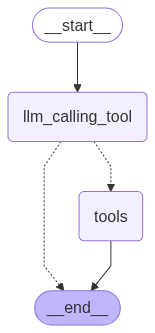

In [17]:
#Build Graph 
from langgraph.graph import StateGraph, START, END 
from langgraph.prebuilt import ToolNode 
from langgraph.prebuilt import tools_condition 

#Node definition 
def llm_calling_tool(state:State):
    return {"messagses": [llm_with_tools.invoke(state["messages"])]}

graph = StateGraph(State)
#Add nodes 
graph.add_node("llm_calling_tool", llm_calling_tool)
graph.add_node("tools", ToolNode(tools))
#Add edge 
graph.add_edge(START, "llm_calling_tool")
graph.add_conditional_edges(
    "llm_calling_tool",
    tools_condition,
)
graph.add_edge("tools", END)

#Compile the graph 
graph_builder = graph.compile()

#Visualize the graph 
from IPython.display import display , Image 
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [18]:
response = graph_builder.invoke({"messages": "What is the recent AI news?"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI news?


In [19]:
graph_builder.invoke({"messages": "What is AGI?"})

{'messages': [HumanMessage(content='What is AGI?', additional_kwargs={}, response_metadata={}, id='3e958d29-0382-4e21-8af3-9dddf268ee56')]}